# Kaggle Titanic survival - K-fold stratification

In our previous example* using logistic regression to classify passengers as likely to survive the Titanic, we used a random split for training and test data. But doing a single assessment like this may lead to an inaccurate assesment of the accuracy.

We could use repeated random splits, but a more robust method is to use ‘stratified k-fold validation’. In this method the model is repeated k times, so that all the data is used once, but only once, as part of the test set. This, alone, is k-fold validation. Stratified k-fold validation adds an extra level of robustness by ensuring that in each of the k training/test splits, the balance of outcomes represents the balance of outcomes (between survivors and non-survivors)in the overall data set. Most commonly 5 or 10 different splits of the data are used.

In a full project it is common to also have some hold-back test data that is used only at the end of model development (with k-fold validation used during model development).

*https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/02_logistic_regression.ipynb

*In this notebook we assume that you have run through the basic logistic regression example in the previous example. We will not explain all steps fully*.

## Load modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Download data

Run the following code if data for Titanic survival has not been previously downloaded.

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Load data and cast all data as float (decimal)

The loading of data assumes that data has been downloaded and saved. 

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

In [4]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Divide into X (features) and y (labels)

We will split into features (X) and label (y) and convert from a Pandas DataFrame to NumPy arrays. NumPy arrays are simpler to refer to by row/column index numbers, and sklearn's k-fold method provides row indices for each set.

In [5]:
# Split data into two DataFrames
X_df = data.drop('Survived',axis=1)
y_df = data['Survived']

# Convert DataFrames to NumPy arrays
X = X_df.values
y = y_df.values

## Define function to standardise data
Standardisation subtracts the mean and divides by the standard deviation, for each feature.
Here we use the sklearn built-in method for standardisation.

In [6]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Training and testing the model for all k-fold splits

The following code:
* Sets up lists to hold results for each k-fold split
* Sets up the k-fold splits using sklearn's `StratifiedKFold` method
* Trains a logistic regression model, and test its it, for each k-fold split
* Adds each k-fold training/test accuracy to the lists

Here wer are using a simple accuracy score, the proportion of predicts that are correct. K-fold validation may also be used for more complicated accuracy assessment.

In [7]:
# Set up lists to hold results for each k-fold run
training_acc_results = []
test_acc_results = []

# Set up splits
number_of_splits = 10
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
for train_index, test_index in skf.split(X, y):
    
    # Get X and Y train/test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)
    
    # Set up and fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std,y_train)
    
    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    
    # Calculate accuracy of training and test sets
    accuracy_train = np.mean(y_pred_train == y_train)
    accuracy_test = np.mean(y_pred_test == y_test)
    
    # Add accuracy to lists
    training_acc_results.append(accuracy_train)
    test_acc_results.append(accuracy_test)

## Show training and test results

In [8]:
# Show individual accuracies on training data
training_acc_results

[0.8164794007490637,
 0.8077403245942572,
 0.816708229426434,
 0.8029925187032418,
 0.816708229426434,
 0.8154613466334164,
 0.8154613466334164,
 0.8117206982543641,
 0.8092269326683291,
 0.813200498132005]

In [9]:
# Show individual accuracies on test data
test_acc_results

[0.7666666666666667,
 0.8,
 0.7752808988764045,
 0.8651685393258427,
 0.7640449438202247,
 0.7640449438202247,
 0.7865168539325843,
 0.797752808988764,
 0.8314606741573034,
 0.8068181818181818]

In [10]:
# Get mean results
mean_training = np.mean(training_acc_results)
mean_test = np.mean(test_acc_results)

# Display each to three decimal places
print ('{0:.3f}, {1:.3f}'.format(mean_training,mean_test))

0.813, 0.796


As expected, the average accuracy is better for the training than the test sets. This is due to the model being slightly 'over-fitted' to the training data, a topic we shall return to in a later notebook.

## Plot results: Box Plot

Box plots show median (orange line), the second and third quartiles (the box), the range (excluding outliers), and any outliers as 'whisker' points. Outliers, by convention, are considerd to be any points outside of the quartiles +/- 1.5 times the interquartile range. The limit for outliers may be changed using the optional `whis` argument in the boxplot.

Medians tend to be an easy reliable guide to the centre of a distribution (i.e. look at the medians to see whether a fit is improving or not, but also look at the box plot to see how much variability there is).

Test sets tend to be more variable in their accuracy measures. Can you think why?

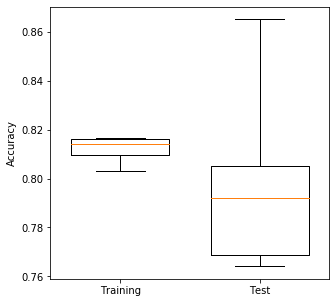

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set up X data 
x_for_box = [training_acc_results, test_acc_results]

# Set up X labels
labels = ['Training', 'Test'] 

# Set up figure
fig = plt.figure(figsize=(5,5))

# Add subplot (can be used to define multiple plots in same figure)
ax1 = fig.add_subplot(1,1,1)

# Define Box Plot (`widths` is optional)
ax1.boxplot(x_for_box, 
            widths=0.7,
            whis=10)

# Set X and Y labels
ax1.set_xticklabels(labels)
ax1.set_ylabel('Accuracy')

# Show plot
plt.show()